In [56]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [57]:
def plot_series(time, series, format="-", start=0, end=None):
    """
    Visualizes time series data

    Args:
      time (array of int) - contains the time steps
      series (array of int) - contains the measurements for each time step
      format - line style when plotting the graph
      label - tag for the line
      start - first time step to plot
      end - last time step to plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    if type(series) is tuple:

      for series_num in series:
        # Plot the time series data
        plt.plot(time[start:end], series_num[start:end], format)

    else:
      # Plot the time series data
      plt.plot(time[start:end], series[start:end], format)

    # Label the x-axis
    plt.xlabel("Time")

    # Label the y-axis
    plt.ylabel("Value")

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

def trend(time, slope=0):
    """
    Generates synthetic data that follows a straight line given a slope value.

    Args:
      time (array of int) - contains the time steps
      slope (float) - determines the direction and steepness of the line

    Returns:
      series (array of float) - measurements that follow a straight line
    """

    # Compute the linear series given the slope
    series = slope * time

    return series

def seasonal_pattern(season_time):
    """
    Just an arbitrary pattern, you can change it if you wish
    
    Args:
      season_time (array of float) - contains the measurements per time step

    Returns:
      data_pattern (array of float) -  contains revised measurement values according 
                                  to the defined pattern
    """

    # Generate the values using an arbitrary pattern
    data_pattern = np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))
    
    return data_pattern

def seasonality(time, period, amplitude=1, phase=0):
    """
    Repeats the same pattern at each period

    Args:
      time (array of int) - contains the time steps
      period (int) - number of time steps before the pattern repeats
      amplitude (int) - peak measured value in a period
      phase (int) - number of time steps to shift the measured values

    Returns:
      data_pattern (array of float) - seasonal data scaled by the defined amplitude
    """
    
    # Define the measured values per period
    season_time = ((time + phase) % period) / period

    # Generates the seasonal data scaled by the defined amplitude
    data_pattern = amplitude * seasonal_pattern(season_time)

    return data_pattern

def noise(time, noise_level=1, seed=None):
    """Generates a normally distributed noisy signal

    Args:
      time (array of int) - contains the time steps
      noise_level (float) - scaling factor for the generated signal
      seed (int) - number generator seed for repeatability

    Returns:
      noise (array of float) - the noisy signal
    """

    # Initialize the random number generator
    rnd = np.random.RandomState(seed)

    # Generate a random number for each time step and scale by the noise level
    noise = rnd.randn(len(time)) * noise_level
    
    return noise

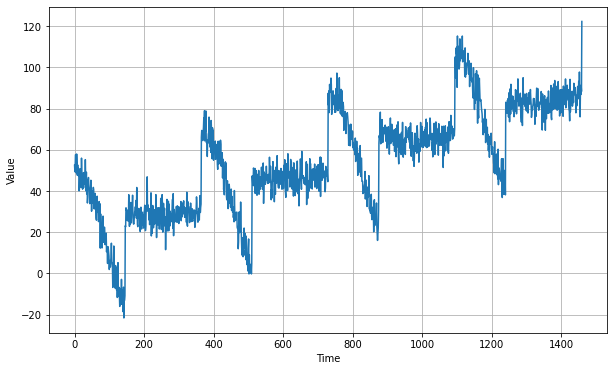

In [58]:
# Parameters
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

# Update with noise
series += noise(time, noise_level, seed=42)

# Plot the results
plot_series(time, series)

In [59]:
# Define the split time
split_time = 1000

# Get the train set 
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

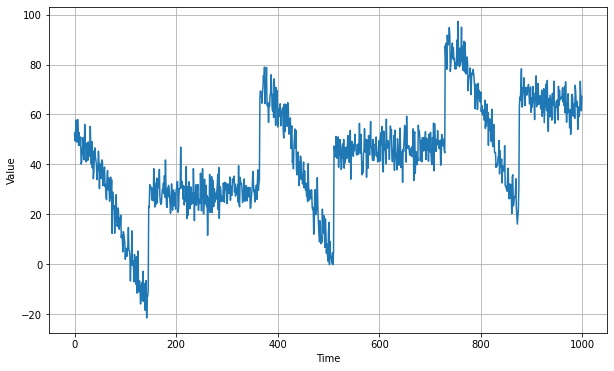

In [60]:
plot_series(time_train, x_train)   

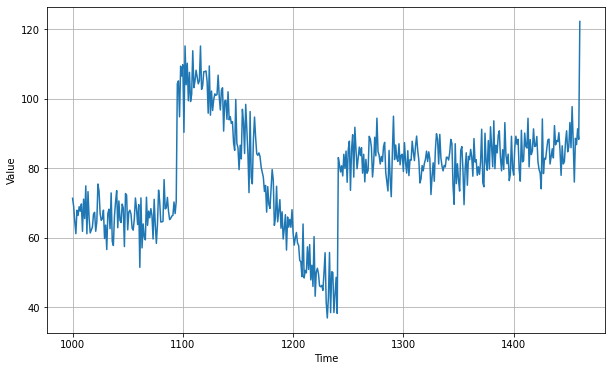

In [61]:
plot_series(time_valid, x_valid)

In [62]:
window_size = 20
batch_size = 32 
shuffle_buffer_size = 1000

In [63]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)

  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)

  dataset = dataset.flat_map(lambda window: window.batch(window_size+1)) 

  dataset = dataset.map(lambda window: (window[:-1], window[-1]))

  dataset = dataset.shuffle(shuffle_buffer)

  dataset = dataset.batch(batch_size).prefetch(1)

  return dataset

In [64]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [65]:
for x,y in dataset:
  print(x.numpy(), y.numpy())

[[ 46.284054   51.48869    37.56802    53.691013   45.266438   43.935593
   41.0233     37.823654   50.228203   46.493633   39.692234   39.68192
   44.49395    54.533825   44.906883   38.70553    45.0092     44.891247
   32.787647   46.018097 ]
 [ 47.52543    43.75058    48.98545    57.16999    46.721287   47.04894
   43.50735    41.55169    49.94979    41.515324   46.151627   43.403996
   48.186077   47.458817   50.97794    43.240307   44.441578   40.89809
   43.571808   47.681534 ]
 [ 75.926186   78.025826   76.279305   73.8866     70.71428    62.228306
   72.14295    70.48897    70.2582     61.960625   62.37761    72.48181
   66.44626    69.47453    65.62681    65.04757    68.99935    61.132607
   63.594288   60.199306 ]
 [ 30.17146    29.214622   37.80533    38.427612   27.942549   26.112188
   32.115417   26.488426   31.91241    29.26776    20.18714    35.023605
   35.793324   23.285662   23.954716   26.874273   26.67722    27.866035
   34.201256   22.851107 ]
 [ 32.67176    37.77

In [66]:
# Print properties of a single batch
for windows in dataset.take(1):
  print(f'data type: {type(windows)}')
  print(f'number of elements in the tuple: {len(windows)}')
  print(f'shape of first element: {windows[0].shape}')
  print(f'shape of second element: {windows[1].shape}')

data type: <class 'tuple'>
number of elements in the tuple: 2
shape of first element: (32, 20)
shape of second element: (32,)


<h2> Build The Model </h2>

In [67]:
model_baseline = tf.keras.models.Sequential([
                                            tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"),
                                            tf.keras.layers.Dense(10, activation="relu"),
                                            tf.keras.layers.Dense(1)
                                  
])
model_baseline.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 10)                210       
                                                                 
 dense_13 (Dense)            (None, 10)                110       
                                                                 
 dense_14 (Dense)            (None, 1)                 11        
                                                                 
Total params: 331
Trainable params: 331
Non-trainable params: 0
_________________________________________________________________


In [68]:
model_baseline.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))

In [69]:
model_baseline.fit(dataset, epochs=100)

Epoch 1/100
31/31 [==============================] - 1s 2ms/step - loss: 432.8868
Epoch 2/100
31/31 [==============================] - 0s 1ms/step - loss: 102.7818
Epoch 3/100
31/31 [==============================] - 0s 2ms/step - loss: 87.0780
Epoch 4/100
31/31 [==============================] - 0s 2ms/step - loss: 79.8994
Epoch 5/100
31/31 [==============================] - 0s 1ms/step - loss: 75.0415
Epoch 6/100
31/31 [==============================] - 0s 2ms/step - loss: 72.2096
Epoch 7/100
31/31 [==============================] - 0s 2ms/step - loss: 70.1848
Epoch 8/100
31/31 [==============================] - 0s 2ms/step - loss: 68.8546
Epoch 9/100
31/31 [==============================] - 0s 2ms/step - loss: 67.5156
Epoch 10/100
31/31 [==============================] - 0s 2ms/step - loss: 65.9834
Epoch 11/100
31/31 [==============================] - 0s 1ms/step - loss: 65.6694
Epoch 12/100
31/31 [==============================] - 0s 2ms/step - loss: 64.3942
Epoch 13/100
31/31 [===

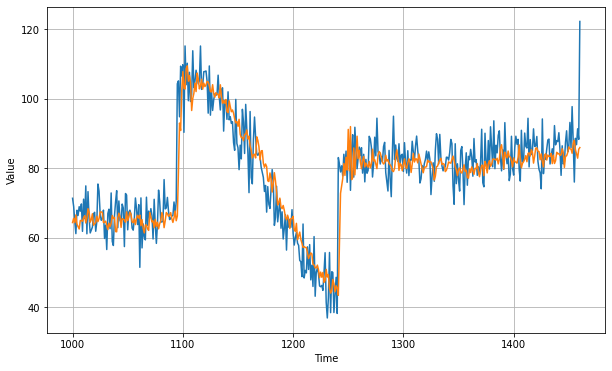

In [70]:
# Initialize a list
forecast = []

# Reduce the original series
forecast_series = series[split_time - window_size:]

# Use the model to predict data points per window size
for time in range(len(forecast_series) - window_size):
  forecast.append(model_baseline.predict(forecast_series[time:time + window_size][np.newaxis]))

# Convert to a numpy array and drop single dimensional axes
results = np.array(forecast).squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

In [71]:
# Compute the metrics
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

45.167473
4.8555737


<h2>Turning the learning rate</h2>

In [72]:
model_tune = tf.keras.models.Sequential([
                                            tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"),
                                            tf.keras.layers.Dense(10, activation="relu"),
                                            tf.keras.layers.Dense(1)
                                  
])


In [73]:

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

In [74]:

optimizer = tf.keras.optimizers.SGD(momentum=0.9)


model_tune.compile(loss="mse", optimizer=optimizer)

In [75]:

history = model_tune.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 1s 2ms/step - loss: 1612.0664 - lr: 1.0000e-08
Epoch 2/100
31/31 [==============================] - 0s 2ms/step - loss: 1401.2424 - lr: 1.1220e-08
Epoch 3/100
31/31 [==============================] - 0s 2ms/step - loss: 1220.3961 - lr: 1.2589e-08
Epoch 4/100
31/31 [==============================] - 0s 2ms/step - loss: 1050.7985 - lr: 1.4125e-08
Epoch 5/100
31/31 [==============================] - 0s 2ms/step - loss: 885.0381 - lr: 1.5849e-08
Epoch 6/100
31/31 [==============================] - 0s 2ms/step - loss: 721.1332 - lr: 1.7783e-08
Epoch 7/100
31/31 [==============================] - 0s 2ms/step - loss: 564.5473 - lr: 1.9953e-08
Epoch 8/100
31/31 [==============================] - 0s 2ms/step - loss: 421.4119 - lr: 2.2387e-08
Epoch 9/100
31/31 [==============================] - 0s 2ms/step - loss: 296.9897 - lr: 2.5119e-08
Epoch 10/100
31/31 [==============================] - 0s 1ms/step - loss: 200.3458 - lr: 2.8184e-08
Epoch

(1e-08, 0.001, 0.0, 300.0)

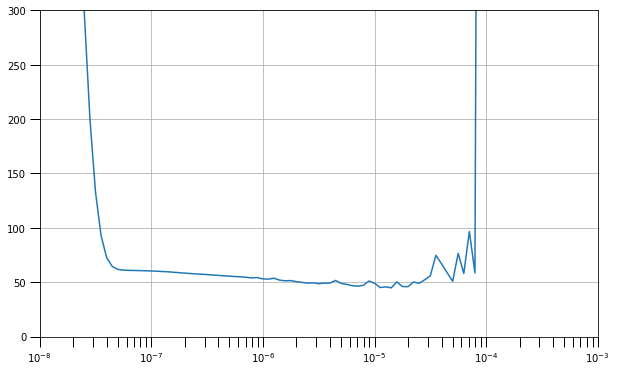

In [77]:
lrs = 1e-8 * (10**(np.arange(100)/20))

plt.figure(figsize=(10,6))

plt.grid(True)

plt.semilogx(lrs, history.history["loss"])

plt.tick_params("both", length=10, width=1, which="both")

plt.axis([1e-8, 1e-3, 0, 300])

In [78]:
# Build the model
model_tune = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
])

In [79]:
# Set the optimizer with the tuned learning rate
optimizer = tf.keras.optimizers.SGD(learning_rate=4e-6, momentum=0.9)

In [80]:
# Set the training parameters
model_tune.compile(loss="mse", optimizer=optimizer)

# Train the model
history = model_tune.fit(dataset, epochs=100)

Epoch 1/100
31/31 [==============================] - 1s 2ms/step - loss: 307.3944
Epoch 2/100
31/31 [==============================] - 0s 2ms/step - loss: 72.3122
Epoch 3/100
31/31 [==============================] - 0s 1ms/step - loss: 63.9014
Epoch 4/100
31/31 [==============================] - 0s 5ms/step - loss: 56.3376
Epoch 5/100
31/31 [==============================] - 1s 8ms/step - loss: 57.1405
Epoch 6/100
31/31 [==============================] - 0s 4ms/step - loss: 55.5731
Epoch 7/100
31/31 [==============================] - 0s 3ms/step - loss: 51.7784
Epoch 8/100
31/31 [==============================] - 0s 3ms/step - loss: 52.0431
Epoch 9/100
31/31 [==============================] - 1s 5ms/step - loss: 51.3845
Epoch 10/100
31/31 [==============================] - 0s 2ms/step - loss: 50.5914
Epoch 11/100
31/31 [==============================] - 0s 1ms/step - loss: 49.2232
Epoch 12/100
31/31 [==============================] - 0s 2ms/step - loss: 48.3923
Epoch 13/100
31/31 [====

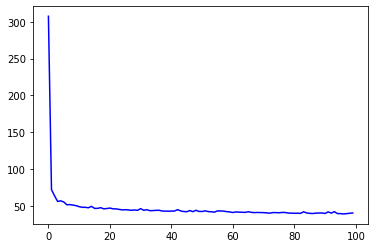

In [81]:
# Plot the loss
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

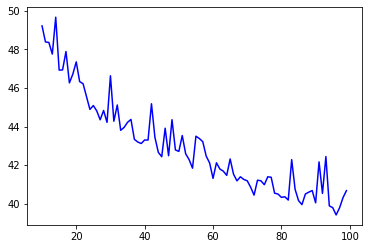

In [82]:
# Plot all but the first 10
loss = history.history['loss']
epochs = range(10, len(loss))
plot_loss = loss[10:]
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()

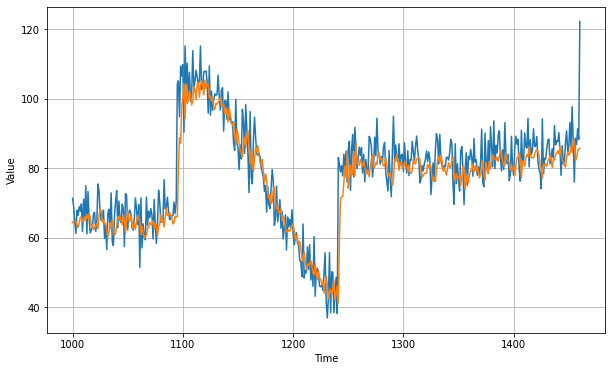

In [83]:
# Initialize a list
forecast = []

# Reduce the original series
forecast_series = series[split_time - window_size:]

# Use the model to predict data points per window size
for time in range(len(forecast_series) - window_size):
  forecast.append(model_tune.predict(forecast_series[time:time + window_size][np.newaxis]))

# Convert to a numpy array and drop single dimensional axes
results = np.array(forecast).squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

In [84]:
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

48.529488
5.038695
